In [20]:
import importlib
import numpy as np 
import math, scipy
from scipy.stats import multivariate_normal, geom, logistic
import matplotlib.pyplot as plt

import md_lvm
import ica
importlib.reload(ica)
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [21]:
Y = np.loadtxt("censored_ica_data100.txt")

In [22]:
d = Y.shape[0]
ndata = Y.shape[1]
p = 2

In [23]:
tmp = np.loadtxt("ica_truth.txt")
true_A = tmp[:d, :]
true_sigma = tmp[d, 0]
alpha = 0.8
a1 = np.abs(np.reshape(true_A[:, 0], [16, 16]))
a2 = np.abs(np.reshape(true_A[:, 1], [16, 16]))

In [24]:
alpha = 0.8
Niter = 5000
N = ndata

In [25]:
sigma = np.zeros((Niter))
A = np.zeros((Niter, d, p))

In [26]:
X = np.random.normal(size = (N, p))  # Initial particle cloud.

In [27]:
sigma0 = np.random.uniform(size = 1)
A0 = np.reshape(np.random.uniform(size = d*p), [d, p])

A[0,:,:] = A0
sigma[0] = sigma0

In [28]:
learning_rate_sigma = 0.001
learning_rate_A = 0.001
h = 0.001

In [29]:
def logICA_gradient_x(sigma, A, X, Y):
    tmp = np.matmul(Y - np.matmul(A, X), A)
    gradient = np.sign(tmp) * np.exp(np.log(np.abs(tmp)) - np.log(sigma**2))
    return gradient + 2*(np.exp(-X)-np.exp(X))/(np.exp(X)+np.exp(-X))

In [30]:
for n in range(1, Niter):
    # IPLA
    gradient_sigma = np.zeros((N))
    gradient_A = np.zeros((N, d, p))
    gradient_x = np.zeros((N, p))
    for i in range(N):
        gradient_sigma[i] =ica.logICA_gradient_sigma(A[n-1, :, :], sigma[n-1], Y[:,i], X[i,:])
        gradient_A[i,:,:] =ica.logICA_gradient_A(A[n-1, :, :], sigma[n-1], Y[:,i], X[i,:])
        gradient_x[i,:] = logICA_gradient_x(sigma[n-1], A[n-1, :, :], X[i,:], Y[:,i])
    sigma[n] = sigma[n-1] + learning_rate_sigma*np.mean(gradient_sigma) + np.sqrt(2*learning_rate_sigma/N)*np.random.normal(0, 1, size = 1)
    A[n,:,:] = A[n-1,:,:] + learning_rate_A*np.mean(gradient_A, axis = 0) + np.sqrt(2*learning_rate_A/N)*np.random.normal(0, 1, size = (d, p))
    X = (X + h*gradient_x
          + np.sqrt(2*h)*np.random.normal(0, 1, (N, p)))

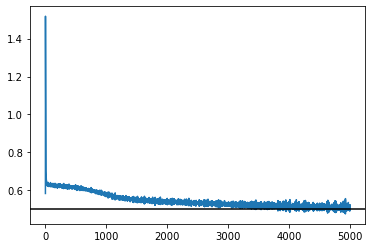

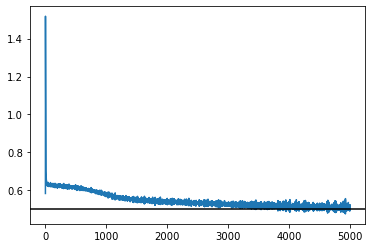

In [31]:
plt.plot(sigma)
plt.axhline(true_sigma, c='k')

In [32]:
A_md_tmp = np.abs(np.reshape(A[:, :, 0], [Niter, 16, 16]))
A_md_tmp2 = np.abs(np.reshape(A[:, :, 1], [Niter, 16, 16]))

In [33]:
for j in range(Niter):
    A_md_tmp[j, :, :] = A_md_tmp[j, :, :]/np.max(A_md_tmp[j, :, :])
    A_md_tmp2[j, :, :] = A_md_tmp2[j, :, :]/np.max(A_md_tmp2[j, :, :])

In [34]:
trace_saem = np.trace(A_md_tmp, axis1 = 1, axis2 = 2)
trace_saem2 = np.trace(A_md_tmp2, axis1 = 1, axis2 = 2)

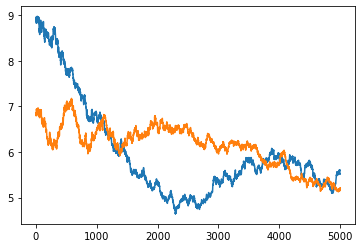

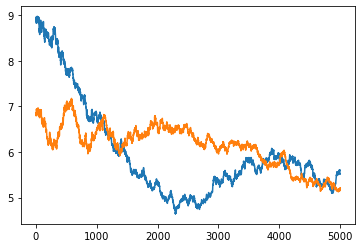

In [35]:
plt.plot(range(Niter), trace_saem, label = 'saem')
plt.plot(range(Niter), trace_saem2, label = 'saem')
# plt.legend(loc='center right', bbox_to_anchor=(1.5, 0))
# plt.savefig('ica_a1_convergence.pdf', bbox_inches="tight")

In [36]:
estimated_a1_md = np.abs(np.reshape(A[Niter-1, :, 0]/np.max(A[Niter-1, :, 0]), [16, 16]))
estimated_a2_md = np.abs(np.reshape(A[Niter-1, :, 1]/np.max(A[Niter-1, :, 1]), [16, 16]))

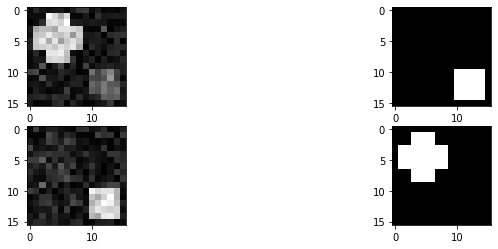

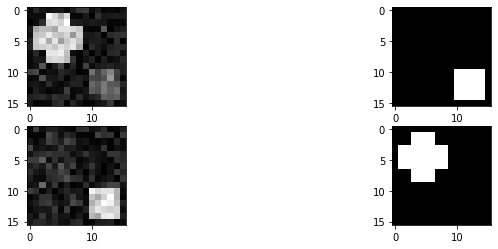

In [37]:
_, axs = plt.subplots(2, 2, figsize = (12, 4))
plt.gray()
axs[0,0].imshow(estimated_a1_md)
axs[0,1].imshow(a1)
axs[1,0].imshow(estimated_a2_md)
axs[1,1].imshow(a2)

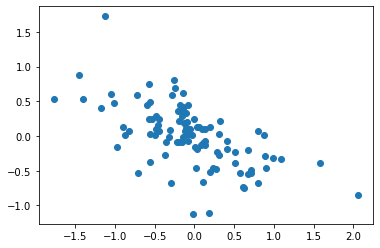

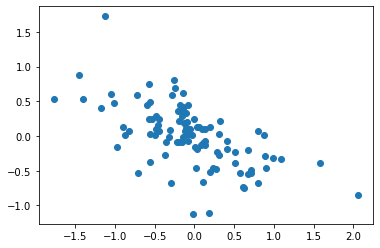

In [38]:
plt.scatter(X[:, 0], X[:, 1])